In [1]:
if "descended" not in locals():
    descended = 1
    %cd ".."
    
import utils

import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

import torch
from wotan import flatten
from scipy.ndimage import gaussian_filter1d

import visualize as vis

/Users/Yke/Desktop/AI/Thesis/ESA/transit-detection-rnn


In [2]:
def plot_results(dic, m, rng=(), split="valid", lbl="", linestyle="-", fill=True, return_c=True, c=None):
    x = np.arange(len(dic["mean"]["metrics"]["train"][()]["acc"]))
    p = plt.plot(x, dic["mean"]["metrics"][split][rng][m], linestyle=linestyle, label=lbl, color=c)
    if fill:
        plt.fill_between(x, dic["mean"]["metrics"][split][rng][m]-dic["std"]["metrics"][split][rng][m],
                        dic["mean"]["metrics"][split][rng][m]+dic["std"]["metrics"][split][rng][m], alpha=0.3, color=p[0].get_color())
    return p[0].get_color() if return_c else None

In [104]:
def load_stats(path):
    with open(path, "rb") as f:
        dic = pickle.load(f)
    return dic

def make_plot(fnames, metric, split, table=False, ylbl="", ylbl2="", title="", 
              pr_curve=False, legend_next=False, figsize=(10,3), show=False, incl_totap=True,
             round_lst=None, prepend="\n", append_lst=None, bbox_help=(1,1)):
    if round_lst is None:
        round_lst = [[2,2] for i in range(len(fnames))]
    if append_lst is None:
        append_lst = [["",""] for i in range(len(fnames))]
    means_list, stds_list = [], [] 
    tot_means, tot_stds = [], []
    for fnm, mname in fnames.items():
        stats = load_stats("models_all/"+fnm+"/stats_avg.pkl")
        mean_dic, std_dic = stats["mean"]["metrics"][split], stats["std"]["metrics"][split]
        rnges, means, stds = [], [], []
        tot_means.append(mean_dic[()][metric])
        tot_stds.append(std_dic[()][metric])
        for rng in list(mean_dic.keys())[1:]:
            rnges.append(np.mean(rng) if rng[-1]<5 else 5)
            means.append(mean_dic[rng][metric])
            stds.append(std_dic[rng][metric])
        means_list.append(np.array(means)), stds_list.append(np.array(stds))

    plt.figure(figsize=figsize)
    for sub in range(2):
        plt.subplot(1,2+pr_curve,sub+1)
        ttl = title if sub==0 else "Relative differences"
        plt.title(ttl, fontsize=14)

        mean_means = 0 if sub==0 else np.array(means_list).mean(0)
        for i, (fname, mname) in enumerate(fnames.items()):
            rounds = round_lst[i]
            app = append_lst[i]
            mean, std = means_list[i], stds_list[i]
            tot_mean, tot_std = tot_means[i], tot_stds[i]
            
            lbl = mname if sub==1 else None
            if incl_totap and lbl is not None:
                lbl += f"{prepend}({round(tot_mean,rounds[0])}{app[0]} $\pm$ {round(tot_std,rounds[1])}{app[1]})"
            
            p = plt.plot(rnges, mean-mean_means, label=lbl)
            plt.scatter(rnges, mean-mean_means, c=p[0].get_color(), zorder=20)
            plt.fill_between(rnges, mean-std-mean_means, mean+std-mean_means, alpha=0.3)
           
        plt.xticks([0,1,2,2,3,4,5], [0,1,2,2,3,4,5], fontsize=13),plt.yticks(fontsize=13)
        
        if sub==1:
            plt.axhline(0, linestyle="--", color="gray")
            ylbl = ylbl if  ylbl2=="" else ylbl2
        else:
            plt.ylim(0,1)
        ylbl = ylbl if sub==0 else ylbl + " from mean"
        plt.ylabel(ylbl, fontsize=14)
        plt.xlabel("Transit depth over \nnoise level ($\delta$/$\sigma$)", fontsize=14)
        if legend_next and not pr_curve:
            plt.legend(fontsize=12, bbox_to_anchor=bbox_help) if sub==1 else None
        elif not legend_next:
            plt.legend(fontsize=12) if sub==0 else None
    if pr_curve:
        plt.subplot(1,2+pr_curve,3)
        thresholds = np.linspace(0,1,20)
        for i, (fname, mname) in enumerate(fnames.items()):
            rounds=round_lst[i]
            app = append_lst[i]
            stats = load_stats("models_all/"+fname+"/stats_avg.pkl")
            tot_mean, tot_std = tot_means[i], tot_stds[i]
            for j, m in enumerate(["thresh_prec", "thresh_rec"]):
                mean = stats["mean"]["metrics"][split][()][m]
                std = stats["std"]["metrics"][split][()][m]
                
                lbl = mname if j==0 else None
                if incl_totap and lbl is not None:
                    lbl += f"{prepend}({round(tot_mean,rounds[0])}{app[0]} $\pm$ {round(tot_std,rounds[1])}{app[1]})"
                p = plt.plot(thresholds, mean, linestyle="-" if j==0 else "--", 
                             color=None if j==0 else p[0].get_color(), linewidth=2, label=lbl)
                plt.fill_between(thresholds, mean-std, mean+std, alpha=0.2, color=p[0].get_color())
        plt.title("Precision-recall tradeoff",fontsize=14) 
        plt.xticks([0.,.2,.4,.6,.8,1.],[0.,.2,.4,.6,.8,1.], fontsize=13), plt.yticks(fontsize=13)
        plt.xlim(-.05,1.05), plt.ylim(0,1.1)
        
        plt.xlabel("Classification threshold", fontsize=14), plt.ylabel("Metric value", fontsize=14)
        if legend_next and pr_curve:
            plt.legend(fontsize=12, bbox_to_anchor=(1,1))
        
        plt.twinx()
        plt.yticks([])
        plt.plot([], linestyle="-", color="gray", label="precision")    
        plt.plot([], linestyle="--", color="gray", label="recall")
        plt.legend(fontsize=12, loc="upper right", framealpha=0.9)#, bbox_to_anchor=(1,1)
        
    plt.tight_layout()
    if show:
        plt.show()

In [87]:
# os.listdir("models_all")

In [88]:
def get_aps(fnames, metric, split):
    for fnm, mname in fnames.items():
        stats = load_stats("models_all/"+fnm+"/stats_avg.pkl")
        mean_dic, std_dic = stats["mean"]["metrics"][split], stats["std"]["metrics"][split]
        mean,std = mean_dic[()][metric],  std_dic[()][metric]
        print("{:20}  :  {:<6.3}   +/-  {:<7.2}  ({:<6.3}, {:<6.3})".format(mname, mean, std, mean-std,mean+std))

# LCSim

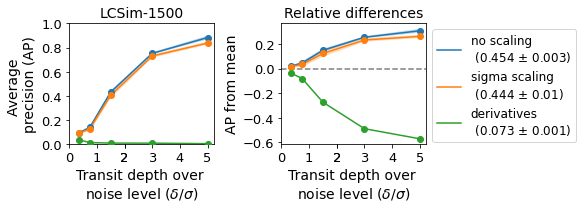

In [101]:
fnames = {"lcsim1500_bigru1_m0":"no scaling",
          "lcsim1500_bigru1_m1":"sigma scaling",
          "lcsim1500_bigru1_m2":"derivatives"}

metric, split = "avgprc", "test"
make_plot(fnames, metric, split, ylbl="Average \nprecision (AP)", ylbl2="AP", 
          title="LCSim-1500", legend_next=1, figsize=(8.2,3), prepend="\n ",
         round_lst=[[3,3],[3,3],[3,3]])
plt.savefig("figures/lcsim1500_AP_pp-basic.pdf")
plt.show()
# metric, split = "aucroc", "test"
# make_plot(fnames, metric, split, ylbl="AUCROC", title="LCSim-1500 test")

In [78]:
get_aps(fnames, metric, split)

no scaling            :  0.454    +/-  0.0025   (0.452 , 0.457 )
sigma scaling         :  0.444    +/-  0.0097   (0.435 , 0.454 )
derivatives           :  0.0726   +/-  0.00057  (0.0721, 0.0732)


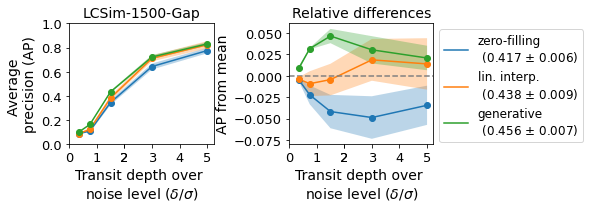

In [102]:
fnames = {"lcsim1500gaps_bigru1_m1_n1":"zero-filling",
          'lcsim1500gaps_bigru1_m1_n2':"lin. interp.",
          'lcsim1500gaps_bigru1gen_m1_n0':"generative"}

metric, split = "avgprc", "test"
make_plot(fnames, metric, split, ylbl="Average \nprecision (AP)", ylbl2="AP", 
          title="LCSim-1500-Gap", figsize=(8.3,3), legend_next=True, prepend="\n ",
         round_lst=[[3,3],[3,3],[3,3]])
plt.savefig("figures/lcsim1500_AP_pp-gaps.pdf")
plt.show()
# metric, split = "aucroc", "test"
# make_plot(fnames, metric, split, ylbl="AUCROC", title="LCSim-1500 test")

In [80]:
get_aps(fnames, metric, split)

zero-filling          :  0.417    +/-  0.0056   (0.411 , 0.422 )
lin. interp.          :  0.438    +/-  0.0088   (0.429 , 0.447 )
generative            :  0.456    +/-  0.0071   (0.449 , 0.463 )


# Lilith

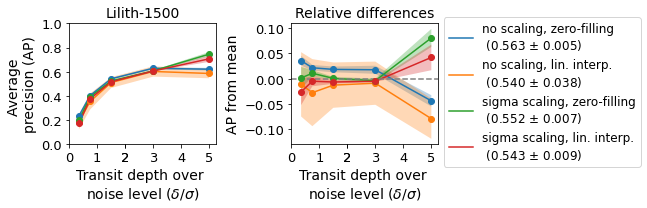

In [107]:
fnames = {'lilith1500basic_bigru1_m0_n1': "no scaling, zero-filling",
          'lilith1500basic_bigru1_m0_n2': "no scaling, lin. interp.",
          'lilith1500basic_bigru1_m1_n1': "sigma scaling, zero-filling",
          'lilith1500basic_bigru1_m1_n2': "sigma scaling, lin. interp."}
          #'lilith1500basic_bigru1_m2_n2': "sigma scaling, lin. interp., derivatives"}

metric, split = "avgprc", "test"
make_plot(fnames, metric, split, ylbl="Average \nprecision (AP)", ylbl2="AP", 
          title="Lilith-1500", legend_next=True, figsize=(9.1,3), prepend="\n ",
          round_lst=[[3,3] for i in range(4)],
         append_lst = [["",""], ["0",""],["",""],["",""]], bbox_help=(1,1.1))
plt.savefig("figures/lilith1500_AP_pp-basic-gaps.pdf")
plt.show()
# metric, split = "aucroc", "test"
# make_plot(fnames, metric, split, ylbl="AUCROC", title="Lilith-1500 test")

In [82]:
get_aps(fnames, metric, split)

no scaling, zero-filling  :  0.563    +/-  0.0046   (0.558 , 0.567 )
no scaling, lin. interp.  :  0.54     +/-  0.038    (0.502 , 0.578 )
sigma scaling, zero-filling  :  0.552    +/-  0.007    (0.545 , 0.559 )
sigma scaling, lin. interp.  :  0.543    +/-  0.0092   (0.534 , 0.552 )


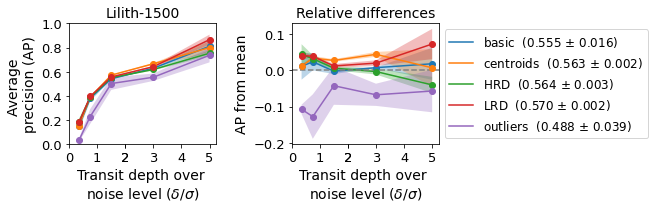

In [111]:
fnames = {'lilith1500basic_bigru1_m1_w3sqrt':"basic",
          'lilith1500basic_bigru1centr_m1_n2_w3sqrt':"centroids",
          'lilith1500hrd_bigru1_m1_n2_w3sqrt':"HRD",
          'lilith1500lrd_bigru1_m1_n2_w3sqrt':"LRD",
          'lilith1500outlier_bigru1_m1_n2_w3sqrt':"outliers"}

metric, split = "avgprc", "test"
make_plot(fnames, metric, split, ylbl="Average \nprecision (AP)", ylbl2="AP", 
          title="Lilith-1500",pr_curve=False, legend_next=True, figsize=(9.2,3),
         round_lst=[[3,3] for i in range(5)], prepend="  ",
         append_lst = [["",""], ["",""],["",""],["0",""],["",""]])
plt.savefig("figures/lilith1500_AP_pp-advanced.pdf")
plt.show()
# metric, split = "aucroc", "test"
# make_plot(fnames, metric, split, ylbl="AUCROC", title="Lilith-1500 test")

In [32]:
get_aps(fnames, metric, split)

basic                 :  0.555    +/-  0.016    (0.539 , 0.57  )
centroids             :  0.563    +/-  0.0025   (0.56  , 0.565 )
HRD                   :  0.564    +/-  0.0029   (0.561 , 0.567 )
LRD                   :  0.57     +/-  0.0016   (0.569 , 0.572 )
outliers              :  0.488    +/-  0.039    (0.449 , 0.527 )


## Data gaps
Simulated gaps, zero-filling, linear interpolation, predicting missing values.

In [190]:
with open("results/low_risk_flatten_lc.pkl", "rb") as f:
    lc = pickle.load(f)

toffs = lc["time"][0]
lc["time"]-=toffs

In [194]:
sigma = np.nanstd(flatten(lc["time"], lc["flux"], method="median", window_length=utils.hour2day(0.5)))
fluxes = [lc["flux"], lc["flat"], np.diff(lc["flux"], prepend=lc["flux"][0])]
fluxes2 = [lc["flux"], np.diff(lc["flux"]/sigma, prepend=lc["flux"][0]),lc["flat"]]
spans = [i-toffs for i in [1321, 1327]]
span_t = utils.min2day(1500 * 2)
cs = [plt.plot([])[0].get_color() for i in range(2)]
plt.close()

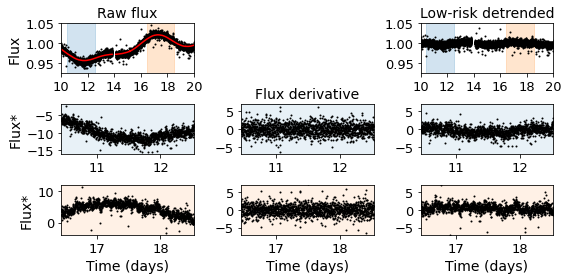

In [198]:
titles=["Raw flux", "Flux derivative", "Low-risk detrended"]
plt.figure(figsize=(8,4))
for i, fl in enumerate(fluxes2):
    if i!=1:
        plt.subplot(3,3,i+1)
        plt.title(titles[i], fontsize=14)
        for j, sp_t in enumerate(spans):
            plt.axvspan(sp_t, sp_t+span_t, alpha=0.2, zorder=-1, color=cs[j])
        vis.plot(lc["time"], fl)
        vis.plot(lc["time"], lc["trend"], scatter=0, c="red", s=1.5) if i==0 else None

        plt.xlim(10,20)
        plt.ylim(0.925, 1.05) if i != 1 else plt.ylim(0.925-1, 1.05-1)
        plt.ylabel("Flux", fontsize=14) if i==0 else None
        plt.xticks([10,12,14,16,18,20],[10,12,14,16,18,20],fontsize=13)
    
    for j, sp_t in enumerate(spans):
        plt.subplot(3,3,i+1+(j+1)*3)
        plt.title(titles[i], fontsize=14) if i==1 and j==0 else None
        plt.axvspan(sp_t, sp_t+span_t, alpha=0.1, zorder=-1, color=cs[j])
        plt.xlim(sp_t, sp_t+span_t)
        msk = (lc["time"]>=sp_t) & (lc["time"]<=sp_t+span_t)
        if i != 1:
            vis.plot(lc["time"][msk], (fl[msk]-1)/sigma)
        else:
            vis.plot(lc["time"][msk], fl[msk])
        plt.ylim(-7,7) if i!=0 else None
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.xlabel("Time (days)", fontsize=14) if j==1 else None
        plt.ylabel("Flux*", fontsize=14) if i==0 else None
#     plt.show()
plt.tight_layout()
plt.savefig("figures/input-range-example.pdf")
plt.show()

In [206]:
from dataloading import loading as dl
sttngs=['gaps',"zero","lininterp"]
nanmodes = [0,1,2]
loaders = {s:{} for s in sttngs}

loaders["original"] = {}
np.random.seed(42)
# purposely used 'valid' here instead of 'train' for train_path
loaders["original"]["show"], _, _ = dl.get_loaders_fn(train_path="data/nn/LCSim-1500/valid", 
                                            valid_path="data/nn/LCSim-1500/valid", test_path=None,
                                            train_batch=128, valid_batch=1000, mode=0, nanmode=0,
                                            scale_median=0, standardize=0, incl_centr=False, insert_gaps=False)
for s, n in zip(sttngs,nanmodes):
    print(s, "show")
    np.random.seed(42)
    loaders[s]["show"], _, _ = dl.get_loaders_fn(train_path="data/nn/LCSim-1500/valid", 
                                            valid_path="data/nn/LCSim-1500/valid", test_path=None,
                                            train_batch=128, valid_batch=1000, mode=0, nanmode=n,
                                            scale_median=0, standardize=0, incl_centr=False, insert_gaps=True)
    np.random.seed(42)
    print(s, "rnn")
    loaders[s]["rnn"], _, _ = dl.get_loaders_fn(train_path="data/nn/LCSim-1500/valid", 
                                            valid_path="data/nn/LCSim-1500/valid", test_path=None,
                                            train_batch=128, valid_batch=1000, mode=1, nanmode=n,
                                            scale_median=0, standardize=1, incl_centr=False, insert_gaps=True)

flux mean = -0.00014082036463644349
flux std = 0.002888606310008239
gaps show
flux mean = -0.0001459215900841745
flux std = 0.0028958310772952984
gaps rnn
flux mean = -0.094193729368438
flux std = 2.6607948866270665
zero show
flux mean = -0.00013421192725385583
flux std = 0.002777494742048481
zero rnn
flux mean = -0.0866350342432105
flux std = 2.5519315030426895
lininterp show
flux mean = -0.00014453756583832154
flux std = 0.002854372226183905
lininterp rnn
flux mean = -0.0916223688852383
flux std = 2.642073555741994


In [207]:
mnames = {'lcsim1500gaps_bigru1_m1_n1': "zero-filling",
 'lcsim1500gaps_bigru1_m1_n2':"linear interpolation",
 'lcsim1500gaps_bigru1gen_m1_n0':"generative network"}

models = {}
for mname, lbl in mnames.items():
    models[lbl] = torch.load("models_all/"+mname+"/model_0.pt")

In [239]:
# pick rn seed
rn_seed = [42, 212][1]
np.random.seed(rn_seed)
# tr = np.where(loaders["gaps"]["show"].dataset.transit)[0]
gp = np.where(np.isnan(loaders["gaps"]["show"].dataset.flux).sum(1) > 200)[0]
rd = np.where(loaders["gaps"]["show"].dataset.rdepth.max(1)[0] > 2)[0]
idx = np.random.choice(np.intersect1d(gp,rd))

with torch.no_grad():
  pts_zero, _ = models["zero-filling"](loaders["zero"]["rnn"].dataset.flux[idx].view(1,-1))
  pts_interp, _ = models["linear interpolation"](loaders["lininterp"]["rnn"].dataset.flux[idx].view(1,-1))
  pts_gen, _, preds = models["generative network"](loaders["gaps"]["rnn"].dataset.flux[idx].view(1,-1))
pts_zero, pts_interp, pts_gen, preds = pts_zero.numpy(), pts_interp.numpy(), pts_gen.numpy(), preds.numpy()

sigma_est = np.nanstd(flatten(t[:300], flux[:300], method="median", window_length=utils.min2day(30)))
gap_mean = -0.094193729368438
gap_std = 2.6607948866270665

fix_pred = lambda p: (((p*gap_std)+gap_mean)*sigma_est+1)

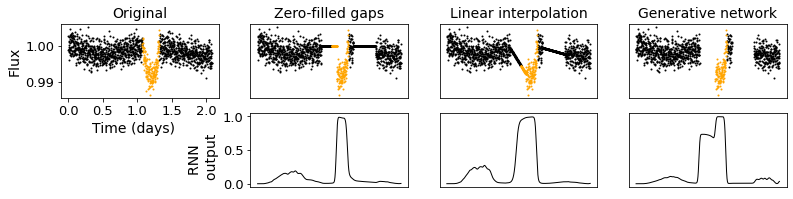

In [262]:
t = np.arange(1500) * utils.min2day(2)
flux = loaders["original"]["show"].dataset.flux[idx].numpy()+1
flux_gap = loaders["gaps"]["show"].dataset.flux[idx].numpy()+1
flux_zero = loaders["zero"]["show"].dataset.flux[idx].numpy()+1
flux_interp = loaders["lininterp"]["show"].dataset.flux[idx].numpy()+1
m = loaders["original"]["show"].dataset.mask[idx].numpy().astype(bool)

w = 4
fig = plt.figure(figsize=(13,3))
gs = fig.add_gridspec(2,4)
pts_list = [None, pts_zero, pts_interp, pts_gen]
flux_list = [flux, flux_zero, flux_interp, flux_gap]
titles = ["Original", "Zero-filled gaps", "Linear interpolation", "Generative network"]
for i, fl in enumerate(flux_list):
  fig.add_subplot(gs[0,i])
  plt.title(titles[i], fontsize=14)
  vis.plot(t[~m], fl[~m])
  vis.plot(t[m], fl[m], c="orange")
  plt.yticks(fontsize=13) if i==0 else plt.yticks([])
  plt.xticks([]) if i>0 else plt.xticks(fontsize=13)
  plt.xlabel("Time (days)   ", fontsize=14) if i==0 else None
  plt.ylabel("Flux", fontsize=14) if i==0 else None
  
  if i==0:
    continue
  fig.add_subplot(gs[1,i])
#   plt.subplot(2,w,i+1+w)
  pts = pts_list[i]
  vis.plot(t, gaussian_filter1d(pts.squeeze(),9), scatter=0)
  plt.ylim(-0.05,1.05)
  plt.xticks([])
  plt.yticks(fontsize=13) if i==1 else plt.yticks([])
  plt.ylabel('RNN    \noutput   ', fontsize=14) if i==1 else None
plt.savefig("figures/gap_examples.pdf")
# plt.tight_layout()

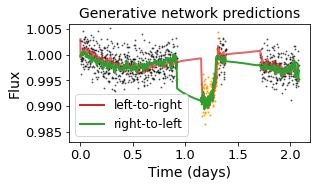

In [261]:
sigma_est = np.nanstd(flatten(t[:300], flux[:300], method="median", window_length=utils.min2day(30)))
gap_mean = -0.094193729368438
gap_std = 2.6607948866270665

fix_pred = lambda p: (((p*gap_std)+gap_mean)*sigma_est+1)
plt.figure(figsize=(4.5,2.7))
plt.title("Generative network predictions", fontsize=14)
vis.plot(t[~m], flux_gap[~m], a=0.5)
vis.plot(t[m], flux_gap[m], c="orange", a=1)
# plt.xticks([]), plt.yticks([]) 
plt.xticks(fontsize=13), plt.yticks(fontsize=13)
plt.ylabel("Flux", fontsize=14), plt.xlabel("Time (days)", fontsize=14)
cs = [plt.plot([])[0].get_color() for i in range(8)]
plt.plot([],c=cs[3],label="left-to-right", linewidth=2)
plt.plot([],c=cs[2],label="right-to-left", linewidth=2)

vis.plot(t, fix_pred(preds[0]) , scatter=0, c=cs[3], s=2, a=.7)
vis.plot(t, fix_pred(preds[1]), scatter=0, c=cs[2], s=2, a=1 )
plt.ylim(0.983,1.006)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig("figures/generative-rnn_predictions.pdf")
plt.show()

In [268]:
np.tan(4), np.tan(6 * np.arctan(4)), np.tan(6)

NameError: name 'x' is not defined